# Домашнее задание: Классификация при помощи CNN

Задание выполнил(а):

    (впишите свои фамилию и имя)

## Общая информация

__Внимание!__  


* Домашнее задание выполняется самостоятельно
* Не допускается помощь в решении домашнего задания от однокурсников или третьих лиц. «Похожие» решения считаются плагиатом, и все задействованные студенты — в том числе и те, у кого списали, — не могут получить за него больше 0 баллов
* Использование в решении домашнего задания генеративных моделей (ChatGPT и так далее) за рамками справочной и образовательной информации для генерации кода задания — считается плагиатом, и такое домашнее задание оценивается в 0 баллов
* Старайтесь сделать код как можно более оптимальным. Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

## О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


## Импорт библиотек

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [ ]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

100%|██████████| 170M/170M [00:05<00:00, 29.9MB/s]


Посмотрим на изображения:

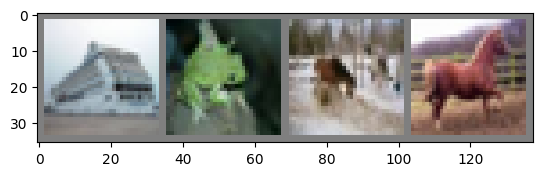

ship frog horse horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [ ]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        in_channels=3
        self.conv = nn.Sequential(
          nn.Conv2d(in_channels,32,(3,3),padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32,32,(3,3),padding=1),
          nn.BatchNorm2d(32),
          # <your code here>
        )
        self.rel2 = nn.ReLU()
        self.avp = nn.AvgPool2d(kernel_size=(8,8),stride=(8,8)) # выход 32 channels, 4*4 HW
        self.lin = nn.Linear(32*4*4,10)
        self.conv11 = nn.Conv2d(in_channels,32,(1,1))
    def forward(self, x):
        out = self.conv(x)+self.conv11(x)
        out = self.rel2(out)
        out = self.avp(out)
        out = torch.flatten(out, start_dim=1) # в вектор
        # print(out.shape)
        out = self.lin(out)
        return out

In [ ]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (rel2): ReLU()
  (avp): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
  (lin): Linear(in_features=512, out_features=10, bias=True)
  (conv11): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
)

Проверим, что выход сети имеет корректную размерность:

In [ ]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [ ]:
def test(model, loader):
    loss_log = []
    acc_log = []
    batch_size = loader.batch_size
    model.eval()

    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = nn.functional.cross_entropy(output, target)
        loss_log.append(loss.item())
        scalar_Loss_Function_value = loss.item()
        preds = output.argmax(dim=1)
        acc = sum(preds==target).sum().item()/batch_size
        acc_log.append(acc)

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    batch_size = train_loader.batch_size

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        # <your code here>
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.cross_entropy(output, target)


        loss_log.append(loss.item())

        # <your code here>
        scalar_Loss_Function_value = loss.item()
        preds = output.argmax(dim=1)
        acc = sum(preds==target).sum().item()/batch_size
        loss.backward()
        optimizer.step()

        acc_log.append(acc)

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.4616240393744961, train acc: 0.482261197440585
 val loss: 1.2337523551697427, val acc: 0.5669547872340426

Epoch 1
 train loss: 1.1425402784478293, train acc: 0.5983775137111518
 val loss: 1.0930975835374062, val acc: 0.6191489361702127

Epoch 2
 train loss: 1.0355299316768891, train acc: 0.6414248171846435
 val loss: 1.0886065741802784, val acc: 0.6253324468085106

Epoch 3
 train loss: 0.9793848683019007, train acc: 0.659135054844607
 val loss: 1.0579294808367465, val acc: 0.6351063829787233

Epoch 4
 train loss: 0.9421700020158966, train acc: 0.6733318098720292
 val loss: 1.000273382663727, val acc: 0.6509308510638298

Epoch 5
 train loss: 0.9176400012900232, train acc: 0.6834723491773309
 val loss: 0.9491051252852095, val acc: 0.6737367021276596

Epoch 6
 train loss: 0.8908634398275581, train acc: 0.6886425959780622
 val loss: 1.040947305395248, val acc: 0.6444148936170213

Epoch 7
 train loss: 0.8752602874905797, train acc: 0.6965836380255942
 val loss: 0.945

Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>
net.eval()
net.zero_grad()
mean_loss, mean_acc = test(net, test_loader)
print("{:.2%}>67%".format(mean_acc))

68.64%>67%


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

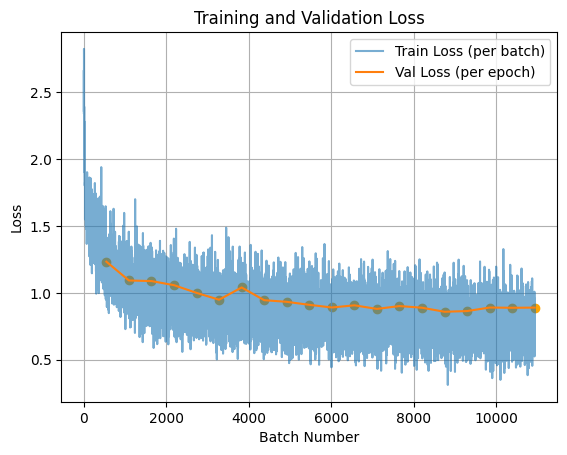

In [ ]:
# <your code here>
# Для функции потерь
plt.plot(train_loss_log, label='Train Loss (per batch)', alpha=0.6)
# Для валидации нужно размазать значения по всем батчам эпохи
val_steps = np.linspace(0, len(train_loss_log), len(val_loss_log)+1)[1:]
plt.plot(val_steps, val_loss_log, label='Val Loss (per epoch)')
plt.scatter(val_steps,val_loss_log,color = 'orange')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)


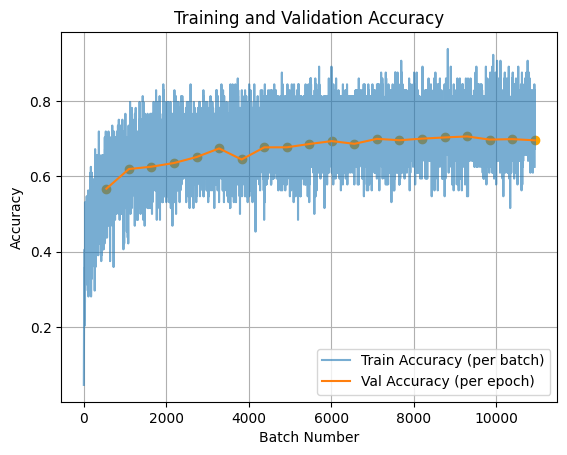

In [ ]:
plt.plot(train_acc_log, label='Train Accuracy (per batch)', alpha=0.6)
# Аналогично для accuracy валидации
plt.plot(val_steps, val_acc_log, label='Val Accuracy (per epoch)')
plt.scatter(val_steps,val_acc_log,color = 'orange')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

In [ ]:
# Забегая вперед, создам словарь, чтобы потом сравнить в 3.1 все рассмотренные способы изменения шага
results = {
    'MultiStepLR': {'train_acc': [], 'val_acc': [], 'val_loss': [], 'lr': []},
    'NoScheduler': {'train_acc': [], 'val_acc': [], 'val_loss': [], 'lr': []},
    'StepLR': {'train_acc': [], 'val_acc': [], 'val_loss': [], 'lr': []},
    'ExponentialLR': {'train_acc': [], 'val_acc': [], 'val_loss': [], 'lr': []},
    'CosineAnnealingLR': {'train_acc': [], 'val_acc': [], 'val_loss': [], 'lr': []}
}

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4975191113935746, train acc: 0.46375114259597805
 val loss: 1.3062065271621055, val acc: 0.535372340425532

Epoch 1
 train loss: 1.1827964243330946, train acc: 0.5835808957952467
 val loss: 1.129248461063872, val acc: 0.602061170212766

Epoch 2
 train loss: 1.0605463675432711, train acc: 0.6312271480804388
 val loss: 1.1341261998135992, val acc: 0.6035239361702127

Epoch 3
 train loss: 1.0008579429368432, train acc: 0.6515939213893968
 val loss: 0.986802569856035, val acc: 0.6577127659574468

Epoch 4
 train loss: 0.9588125865681734, train acc: 0.6665333638025595
 val loss: 1.0325049301411242, val acc: 0.6392952127659575

Epoch 5
 train loss: 0.9273251062991197, train acc: 0.676359689213894
 val loss: 0.9563452728251194, val acc: 0.6688164893617021

Epoch 6
 train loss: 0.909675386204798, train acc: 0.6811871572212066
 val loss: 0.9511104520331037, val acc: 0.6716090425531915

Epoch 7
 train loss: 0.8902757112788108, train acc: 0.6892710237659964
 val loss: 0.9166

Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>
net.eval()
net.zero_grad()
mean_loss2, mean_acc2 = test(net, test_loader)
print("{:.2%}>{:.2%}".format(mean_acc2,mean_acc))

70.99%>68.64%


In [ ]:
# Сразу туда запишу текущие результаты:
results['MultiStepLR']['train_acc'] = tr_acc_log
results['MultiStepLR']['val_acc'] = val_acc_log
results['MultiStepLR']['val_loss'] = val_loss_log

def get_lr_history(scheduler, n_epochs): # эта функция нужна чтобы запоминать историю размера lr. Потом нарисую график для сравнения разных методов
    lr_history = []
    for _ in range(n_epochs):
        lr_history.append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()
    return lr_history
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
results['MultiStepLR']['lr'] = get_lr_history(scheduler, 20)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.8275879623685065, train acc: 0.35820383912248627
 val loss: 1.6184920950138824, val acc: 0.43470744680851064

Epoch 1
 train loss: 1.5500756489075516, train acc: 0.45718121572212067
 val loss: 1.4668001154635815, val acc: 0.48271276595744683

Epoch 2
 train loss: 1.4315801035115663, train acc: 0.49891453382084094
 val loss: 1.3885898620524304, val acc: 0.5072473404255319

Epoch 3
 train loss: 1.3525386824250438, train acc: 0.5263368372943327
 val loss: 1.3069502216704347, val acc: 0.539561170212766

Epoch 4
 train loss: 1.2953488190387676, train acc: 0.5490173674588665
 val loss: 1.2537574047737934, val acc: 0.5595744680851064

Epoch 5
 train loss: 1.2464885871850595, train acc: 0.5662991316270567
 val loss: 1.2246630006648125, val acc: 0.5692154255319148

Epoch 6
 train loss: 1.2052616643731293, train acc: 0.579981718464351
 val loss: 1.1743777183776205, val acc: 0.5882978723404255

Epoch 7
 train loss: 1.1646517491209878, train acc: 0.5948069012797075
 val loss

In [ ]:
net.eval()
net.zero_grad()
mean_loss, mean_acc = test(net, test_loader)
print("LR=0.001=Const: {:.2%}".format(mean_acc))

LR=0.001=Const: 66.49%


**Результаты в случае, если lr=0.001 сразу, даже лучше, так как accuracy 72%>70.53%**

In [ ]:
results['NoScheduler']['train_acc'] = tr_acc_log
results['NoScheduler']['val_acc'] = val_acc_log
results['NoScheduler']['val_loss'] = val_loss_log
results['NoScheduler']['lr'] = [0.001 for _ in range(20)]

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

**Способ 1. StepLR**

Похож на MultiStepLR, но уменьшает шаг в gamma раз каждые step_size эпох

Формула:

LR = initial_lr * gamma^(количество пройденных milestones до текущей эпохи)

In [ ]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
# Эпохи 0-3 будут обучаться с lr=0.1, потом
# Эпохи 4-7 с lr = 0.01
# Эпохи 8-11 с lr = 0.001
# Эпохи 12-15 c lr=0.0001
# Эпохи 16-19 c lr = 0.00001
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.492378962977059, train acc: 0.46703610603290674
 val loss: 1.3624717387747258, val acc: 0.5292553191489362

Epoch 1
 train loss: 1.157763004956777, train acc: 0.593235831809872
 val loss: 1.0624314120475282, val acc: 0.6285904255319149

Epoch 2
 train loss: 1.062654784981032, train acc: 0.628713436928702
 val loss: 1.0047018576175608, val acc: 0.6481382978723405

Epoch 3
 train loss: 1.0091460642474661, train acc: 0.6479090493601463
 val loss: 1.0732983670336136, val acc: 0.6273936170212766

Epoch 4
 train loss: 0.8775385391559636, train acc: 0.6958980804387569
 val loss: 0.9154699576661942, val acc: 0.6808510638297872

Epoch 5
 train loss: 0.8542054632246168, train acc: 0.7043247257769653
 val loss: 0.9029734134674072, val acc: 0.6875664893617022

Epoch 6
 train loss: 0.848408930425888, train acc: 0.7062385740402194
 val loss: 0.8980906651375141, val acc: 0.6910239361702127

Epoch 7
 train loss: 0.838692874588086, train acc: 0.7098663162705667
 val loss: 0.90066

In [ ]:
net.eval()
net.zero_grad()
mean_loss, mean_acc = test(net, test_loader)
print("StepLR: {:.2%}".format(mean_acc))

StepLR: 68.72%


In [ ]:
results['StepLR']['train_acc'] = tr_acc_log
results['StepLR']['val_acc'] = val_acc_log
results['StepLR']['val_loss'] = val_loss_log
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
results['StepLR']['lr'] = get_lr_history(scheduler,20)

**Способ 2. ExponentialLR**

Уменьшает lr на __каждой__ эпохе, то есть как StepLR(step_size=1)


In [ ]:

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.6)
# Эпоха 0 будут обучаться с lr=0.1, потом
# Эпоха 1 с lr = 0.06
# Эпоха 2 с lr = 0.036
# Эпоха 3 c lr=0.0216
# ....
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.522909966312771, train acc: 0.4564099634369287
 val loss: 1.2653398904394597, val acc: 0.5550531914893617

Epoch 1
 train loss: 1.1648539017061865, train acc: 0.5882941042047533
 val loss: 1.057399973209868, val acc: 0.63125

Epoch 2
 train loss: 1.0184656344558465, train acc: 0.6476234003656307
 val loss: 0.9949553129520822, val acc: 0.6560505319148936

Epoch 3
 train loss: 0.9523497999695145, train acc: 0.6683043875685558
 val loss: 0.9506357299520615, val acc: 0.6702127659574468

Epoch 4
 train loss: 0.9099300948313864, train acc: 0.6841864716636198
 val loss: 0.9505038715423422, val acc: 0.6691489361702128

Epoch 5
 train loss: 0.8826570507595265, train acc: 0.6947840493601463
 val loss: 0.9209357205857622, val acc: 0.6831117021276596

Epoch 6
 train loss: 0.865895383863606, train acc: 0.6993829981718465
 val loss: 0.907483371775201, val acc: 0.6865691489361702

Epoch 7
 train loss: 0.8553265733082508, train acc: 0.7052102376599635
 val loss: 0.89693793844669

In [ ]:
net.eval()
net.zero_grad()
mean_loss, mean_acc = test(net, test_loader)
print("ExponLR: {:.2%}".format(mean_acc))

ExponLR: 68.56%


In [ ]:
results['ExponentialLR']['train_acc'] = tr_acc_log
results['ExponentialLR']['val_acc'] = val_acc_log
results['ExponentialLR']['val_loss'] = val_loss_log
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.6)
results['ExponentialLR']['lr'] = get_lr_history(scheduler, n_epochs=20)

**Способ 3. CosineAnnealingLR**

Уменьшает lr на __периодически__ по эпохам, с периодом


In [ ]:

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.001)
# Эпохи 0-4 будут обучаться с lr=cos(..) плавно снижаясь по косинусу
# Эпохи 5-9 принимают те же самые значения lr что и эпохи 0-4
# ....
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.495353019433658, train acc: 0.4680358775137112
 val loss: 1.2882133871951003, val acc: 0.5482047872340425

Epoch 1
 train loss: 1.1556997456106015, train acc: 0.5970063985374772
 val loss: 1.1997534079754606, val acc: 0.5851063829787234

Epoch 2
 train loss: 1.024788672244091, train acc: 0.6446240859232175
 val loss: 1.0071407105060335, val acc: 0.6496675531914894

Epoch 3
 train loss: 0.9335683339038758, train acc: 0.6771880712979891
 val loss: 0.9629341759580247, val acc: 0.6638962765957447

Epoch 4
 train loss: 0.8717917833729244, train acc: 0.6996400822669104
 val loss: 0.9088978501076393, val acc: 0.6815159574468085

Epoch 5
 train loss: 0.8462578576923071, train acc: 0.708123857404022
 val loss: 0.8946079502714441, val acc: 0.6871010638297872

Epoch 6
 train loss: 0.8585380611624535, train acc: 0.7044104204753199
 val loss: 0.9037575703986147, val acc: 0.6825132978723404

Epoch 7
 train loss: 0.8985587016320098, train acc: 0.6885854661791591
 val loss: 0.92

In [ ]:
net.eval()
net.zero_grad()
mean_loss, mean_acc = test(net, test_loader)
print("CosAnnealingRL: {:.2%}".format(mean_acc))

CosAnnealingRL: 67.76%


In [ ]:
results['CosineAnnealingLR']['train_acc'] = tr_acc_log
results['CosineAnnealingLR']['val_acc'] = val_acc_log
results['CosineAnnealingLR']['val_loss'] = val_loss_log
results['CosineAnnealingLR']['lr'] = get_lr_history(scheduler,20)

**Теперь выведем графики которые соответствуют всем способам уменьшения LR**

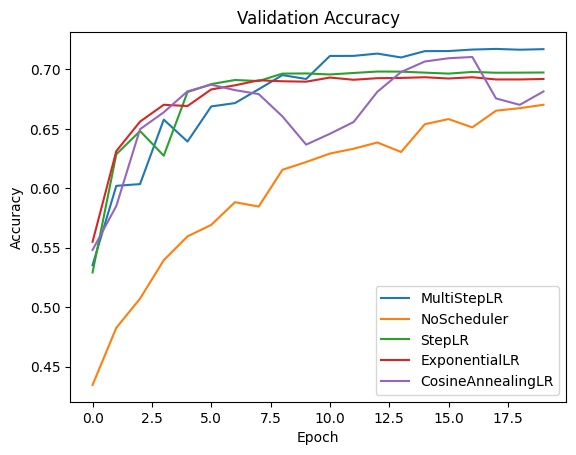

In [ ]:
for method in results:
    plt.plot(results[method]['val_acc'], label=method)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

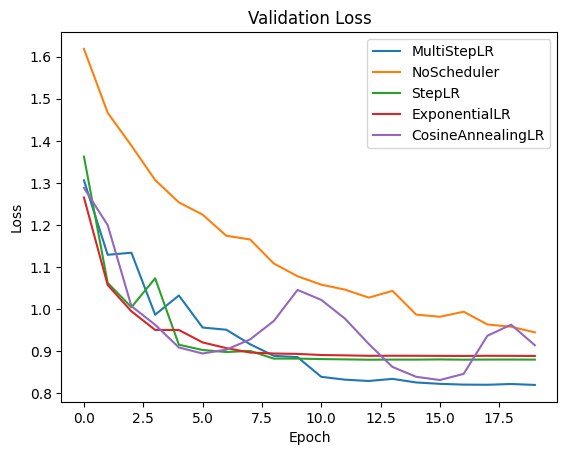

In [ ]:
for method in results:
    plt.plot(results[method]['val_loss'], label=method)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

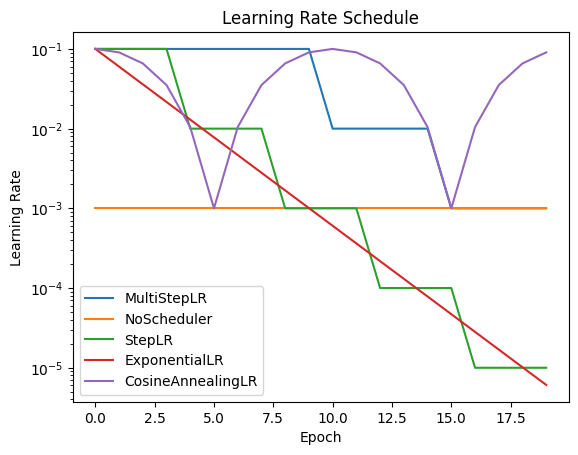

In [ ]:
for method in results:
    plt.plot(results[method]['lr'], label=method)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')  # Логарифмическая шкала для лучшей визуализации
plt.legend()

Протестировав разные способы на тесте по Accuracy:

*   No scheduler (lr=0.1):  68.64%
*   MultiStepLR:            70.99%
*   StepLR:                 68.72%
*   No scheduler (lr=0.001):66.49%
*   ExponLR:                68.56%
*   CosineAnnealingLR:      67.76%

По итогу:


*   Лучше всего себя показал MultiStepLR, дав наибольший Accuracy. Также хорошо StepLR, NoScheduler (lr=0.1).
*   Для этой задачи для оптимизатора больше подходят значения lr=0.001 (порядка $10^{-3}$)
*   Параметр lr выгодно менять с некоторым шагом по эпохам (MultiStepLR)



## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

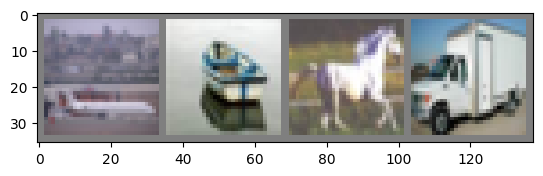

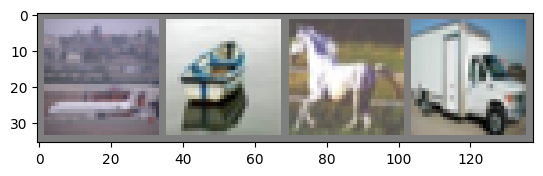

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4583238507101697, train acc: 0.4812328610603291
 val loss: 1.2517507342582053, val acc: 0.5479388297872341

Epoch 1
 train loss: 1.1526666171372046, train acc: 0.5989773765996343
 val loss: 1.1240316621800686, val acc: 0.6065824468085106

Epoch 2
 train loss: 1.0469142521103296, train acc: 0.6372543418647166
 val loss: 1.007299060517169, val acc: 0.6485372340425531

Epoch 3
 train loss: 0.9955394586217905, train acc: 0.6550502742230347
 val loss: 0.9822985319381065, val acc: 0.6643617021276595

Epoch 4
 train loss: 0.960911508452086, train acc: 0.6659335009140768
 val loss: 0.996483649852428, val acc: 0.6508643617021277

Epoch 5
 train loss: 0.9268021556315518, train acc: 0.6774737202925045
 val loss: 0.9317675400287547, val acc: 0.6741356382978724

Epoch 6
 train loss: 0.9078788665792406, train acc: 0.6852719378427788
 val loss: 0.9993886488549253, val acc: 0.6484707446808511

Epoch 7
 train loss: 0.895849673414579, train acc: 0.6905564442413162
 val loss: 0.887

Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>
net.eval()
net.zero_grad()
mean_loss, mean_acc = test(net, test_loader)
print("Augumented: {:.2%}".format(mean_acc))

Augumented: 72.23%


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

Преобразования делятся на геометрические, цвета, и обрезки. Буду использовать следующие преобразования:

*  Геометрическое: RandomRotation(15) - поворачивает на случайный угол от 0 до 15 градусов в случайном направлении
*  Цвета: transforms.ColorJitter(brightness=0.2, contrast=0.2) - меняет яркость от 80% до 120%, контраст тоже в диапазоне [80%, 120%]
*  Обрезка: transforms.RandomResizedCrop(32, scale=(0.8, 1.0)) - выполняет случайную обрезку, итоговое изображение 32*32. Площадь итогового изображения $S_{new} = [0.8*S_{изначальное}, 1*S_{изначальное}]$

In [ ]:
# <your code here>

transform_rand_rot = transforms.Compose([
        transforms.RandomRotation(15),  # Поворот на ±15 градусов
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform_color_jitter = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

transform_resize = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_together = transform_resize = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


**Аугментация случайным вращением**

In [ ]:
# Аугментация случайным вращением
train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_rand_rot
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.548565985515741, train acc: 0.4459266453382084
 val loss: 1.3633842285643232, val acc: 0.504122340425532

Epoch 1
 train loss: 1.2870909907264292, train acc: 0.543675731261426
 val loss: 1.2152114754027508, val acc: 0.5631648936170213

Epoch 2
 train loss: 1.1812214649791473, train acc: 0.5836094606946983
 val loss: 1.1581459664283915, val acc: 0.5936170212765958

Epoch 3
 train loss: 1.1131448156219077, train acc: 0.6094321297989032
 val loss: 1.1102081866974527, val acc: 0.6050531914893617

Epoch 4
 train loss: 1.0690589690992993, train acc: 0.6261997257769653
 val loss: 1.0652771077257521, val acc: 0.624468085106383

Epoch 5
 train loss: 1.0340073430124106, train acc: 0.6405678702010968
 val loss: 1.0690534840238854, val acc: 0.6216755319148937

Epoch 6
 train loss: 1.0032826803719976, train acc: 0.6479947440585009
 val loss: 1.0154636012746934, val acc: 0.6454787234042553

Epoch 7
 train loss: 0.9963963670312159, train acc: 0.6501371115173674
 val loss: 1.011

In [ ]:

net.eval()
net.zero_grad()
mean_loss, mean_acc = test(net, test_loader)
print("Random rotate: {:.2%}".format(mean_acc))

Random rotate: 70.44%


**Аугментация случайным увеличиванием контраста и яркости**

In [ ]:
# Аугментация случайным увеличиванием контраста и яркости
train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_color_jitter
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.52191751835769, train acc: 0.4582666819012797
 val loss: 1.4808210925852998, val acc: 0.4745345744680851

Epoch 1
 train loss: 1.196710073315901, train acc: 0.5838665447897623
 val loss: 1.2254554007915741, val acc: 0.5756648936170212

Epoch 2
 train loss: 1.087855864486485, train acc: 0.6232575411334552
 val loss: 1.1040514096300653, val acc: 0.614095744680851

Epoch 3
 train loss: 1.037621914468692, train acc: 0.6411106032906764
 val loss: 1.1497364452544678, val acc: 0.5977393617021277

Epoch 4
 train loss: 0.9861299057765243, train acc: 0.6576496800731262
 val loss: 1.0658743340918357, val acc: 0.6337765957446808

Epoch 5
 train loss: 0.9709263788280801, train acc: 0.6634483546617916
 val loss: 0.9882714573373186, val acc: 0.6527925531914893

Epoch 6
 train loss: 0.9479400584750027, train acc: 0.6720463893967094
 val loss: 0.9661540807561672, val acc: 0.660970744680851

Epoch 7
 train loss: 0.9335755446493299, train acc: 0.6791019195612431
 val loss: 0.942612

In [ ]:

net.eval()
net.zero_grad()
mean_loss, mean_acc = test(net, test_loader)
print("Augmentation color: {:.2%}".format(mean_acc))

Augmentation color: 56.43%


Судя по низкому test accuracy, аугментация слишком сложная для 20 эпох, может, модель не успела обучиться за 20 эпох на этих данных

**Аугментация случайной обрезкой картинки**

In [ ]:
# Аугментация случайной обрезкой
train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_resize
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.657314619590857, train acc: 0.40353633455210236
 val loss: 1.515585628976213, val acc: 0.4542553191489362

Epoch 1
 train loss: 1.445302497534255, train acc: 0.4851748171846435
 val loss: 1.3835690122969606, val acc: 0.503656914893617

Epoch 2
 train loss: 1.3425676631971077, train acc: 0.523051873857404
 val loss: 1.35922119313098, val acc: 0.5210771276595745

Epoch 3
 train loss: 1.289244841178113, train acc: 0.5446755027422303
 val loss: 1.283576508532179, val acc: 0.5537234042553192

Epoch 4
 train loss: 1.2477672207943917, train acc: 0.5602148080438757
 val loss: 1.2914953363702653, val acc: 0.5460106382978723

Epoch 5
 train loss: 1.2261997307676284, train acc: 0.5692698811700183
 val loss: 1.2230955555083904, val acc: 0.5716090425531914

Epoch 6
 train loss: 1.1962407210627248, train acc: 0.5778393510054844
 val loss: 1.1934949058167479, val acc: 0.5791223404255319

Epoch 7
 train loss: 1.1842638716183371, train acc: 0.5852947897623401
 val loss: 1.2426931

In [ ]:

net.eval()
net.zero_grad()
mean_loss, mean_acc = test(net, test_loader)
print("Augmentation resize: {:.2%}".format(mean_acc))

Augmentation resize: 64.58%


**Со всеми видами рассмотренных аугментаций**

In [ ]:
# Все вместе: геометрия + цвет + случайная обрезка
train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_together
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.647872079878882, train acc: 0.4092778793418647
 val loss: 1.5218871319547613, val acc: 0.45398936170212767

Epoch 1
 train loss: 1.434079479909684, train acc: 0.48783135283363804
 val loss: 1.355922549836179, val acc: 0.5106382978723404

Epoch 2
 train loss: 1.3450450662938942, train acc: 0.5217378884826326
 val loss: 1.3188451386512594, val acc: 0.5303191489361702

Epoch 3
 train loss: 1.291884147815774, train acc: 0.543989945155393
 val loss: 1.2481662012161092, val acc: 0.5580452127659574

Epoch 4
 train loss: 1.2588584296664111, train acc: 0.5558158135283364
 val loss: 1.260709925408059, val acc: 0.5455452127659575

Epoch 5
 train loss: 1.2243348967004737, train acc: 0.5677845063985375
 val loss: 1.2322582374227808, val acc: 0.564627659574468

Epoch 6
 train loss: 1.2016633485309385, train acc: 0.5792390310786106
 val loss: 1.208101825257565, val acc: 0.5710106382978724

Epoch 7
 train loss: 1.1884106902143419, train acc: 0.5835523308957953
 val loss: 1.20148

In [ ]:

net.eval()
net.zero_grad()
mean_loss, mean_acc = test(net, test_loader)
print("Augmentation full: {:.2%}".format(mean_acc))

Augmentation full: 63.77%


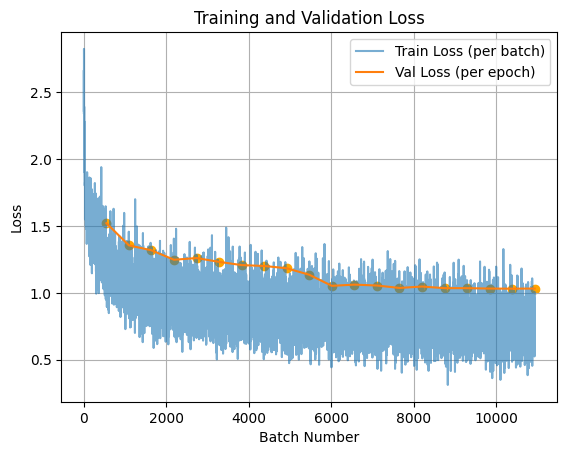

In [ ]:
# <your code here>
# Для функции потерь
plt.plot(train_loss_log, label='Train Loss (per batch)', alpha=0.6)
# Для валидации нужно размазать значения по всем батчам эпохи
val_steps = np.linspace(0, len(train_loss_log), len(val_loss_log)+1)[1:]
plt.plot(val_steps, val_loss_log, label='Val Loss (per epoch)')
plt.scatter(val_steps,val_loss_log,color = 'orange')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)


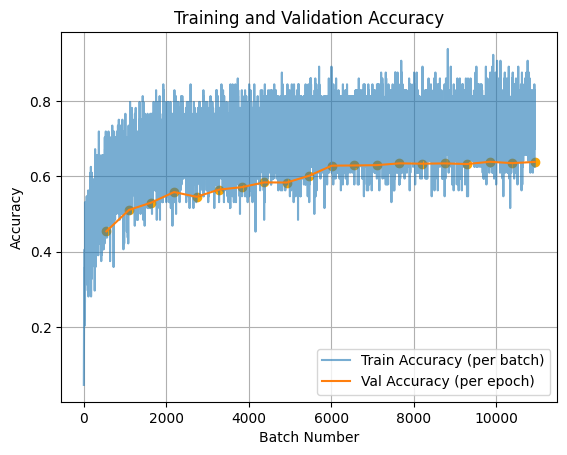

In [ ]:
plt.plot(train_acc_log, label='Train Accuracy (per batch)', alpha=0.6)
# Аналогично для accuracy валидации
plt.plot(val_steps, val_acc_log, label='Val Accuracy (per epoch)')
plt.scatter(val_steps,val_acc_log,color = 'orange')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

Your answers here:

**Ответ**

Судя по всему, аугментация с цветом colorJitter, и аугментация с обрезкой - слишком сложные, для нашей модели (модель слишком простая для того чтобы выделить устойчивые признаки тестовых данных с этими аугментациями), поэтому accuracy на test падает по сравнению с тем как было без аугментации.

В то же время, аугментация вида horizontalFlip, RandomRotate(15) - дают такой же, или лучший accuracy на тестовых данных, чем без них. Значит они позволяют продуктивно расширить библиотеку картинок (обобщать зависимости обучающей выборки) для обучения модели, ускоряя подбор её параметров (количество эпох для подбора параметров уменьшается).

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [ ]:
# <your code here>
!pip install wandb -q
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kateuwek (kateuwek-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Инициализация WandB
wandb.init(project="cifar10-training-2_CNN", config={
    "learning_rate": 0.1,
    "momentum": 0.9,
    "epochs": 20,
    "batch_size": 64,
    "architecture": "CustomCNN"
})

lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,█▇██▇████▇█▇██████▇▇▁▃▄
val_loss,▁▂▁▁▂▂▁▂▁▁▁▂▁▁▁▁▁▁▃▂█▆▆
lr,0.1
val_acc,0.60944
val_loss,1.12529


In [ ]:

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        wandb.log({
            "val_loss": val_loss,
            "val_acc": val_acc,
            "lr": optimizer.param_groups[0]['lr'] # выводим learning rate чтобы был)
        })

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        if scheduler:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

In [ ]:
# Обучение

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)
wandb.finish()

Epoch 0
 train loss: 1.500375644816341, train acc: 0.46543647166361973
 val loss: 1.2649847639367935, val acc: 0.5495345744680851

Epoch 1
 train loss: 1.1714143149377658, train acc: 0.589779478976234
 val loss: 1.117720079421997, val acc: 0.6143617021276596

Epoch 2
 train loss: 1.0575400334825464, train acc: 0.6328553473491774
 val loss: 1.0375201577835895, val acc: 0.6307180851063829

Epoch 3
 train loss: 0.9993161489366396, train acc: 0.6523366087751371
 val loss: 1.048878495997571, val acc: 0.629720744680851

Epoch 4
 train loss: 0.9612126935552635, train acc: 0.6655050274223034
 val loss: 0.9536409190360536, val acc: 0.6662234042553191

Epoch 5
 train loss: 0.929928695697889, train acc: 0.676673903107861
 val loss: 0.9873240478495334, val acc: 0.6561835106382978

Epoch 6
 train loss: 0.9065543923125189, train acc: 0.6858432358318098
 val loss: 0.9380908760618656, val acc: 0.6736702127659574

Epoch 7
 train loss: 0.8862914148806654, train acc: 0.6876999542961609
 val loss: 0.97743

lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▄▆▆▆▆▇▆▇▆█▇███▇▇█
val_loss,█▅▄▄▃▃▂▃▂▂▂▃▁▂▁▁▁▂▁▁
lr,0.1
val_acc,0.70997
val_loss,0.86395
